In [0]:
# @Vishal Dhiman

try:
  %tensorflow_version 2.x
except Exception:
  pass



[Out]: Data Loaded Successfully.

[Out]: Preprocessing done.

[Out]: Data Frame:
     MPG  Cylinders  Displacement  Horsepower  ...  Model Year  USA  Europe  Japan
0  18.0          8         307.0       130.0  ...          70  1.0     0.0    0.0
1  15.0          8         350.0       165.0  ...          70  1.0     0.0    0.0
2  18.0          8         318.0       150.0  ...          70  1.0     0.0    0.0
3  16.0          8         304.0       150.0  ...          70  1.0     0.0    0.0
4  17.0          8         302.0       140.0  ...          70  1.0     0.0    0.0
5  15.0          8         429.0       198.0  ...          70  1.0     0.0    0.0
6  14.0          8         454.0       220.0  ...          70  1.0     0.0    0.0
7  14.0          8         440.0       215.0  ...          70  1.0     0.0    0.0
8  14.0          8         455.0       225.0  ...          70  1.0     0.0    0.0
9  15.0          8         390.0       190.0  ...          70  1.0     0.0    0.0

[10 rows x 10 

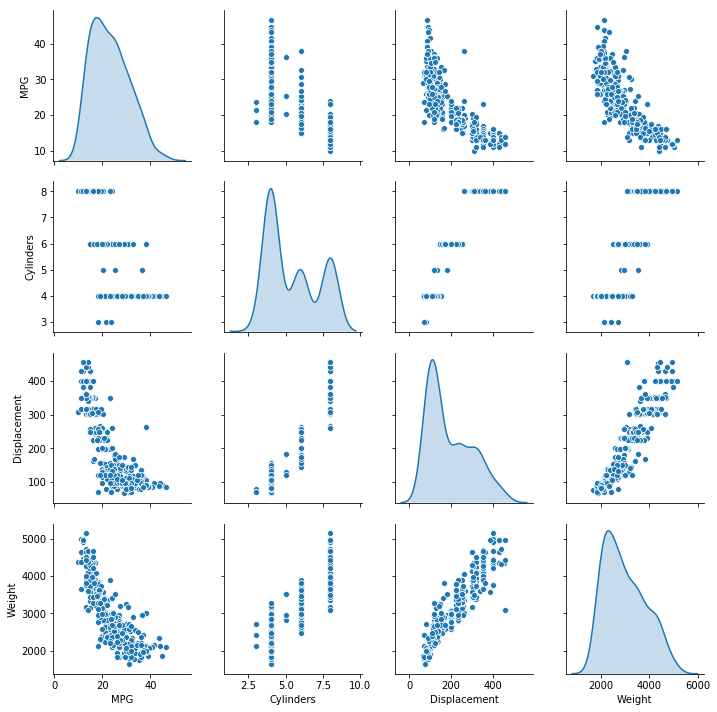

In [7]:
from __future__ import absolute_import,print_function,division,unicode_literals
import pathlib

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100==0: print("")
    print(".",end="")

class MPG_data:
  
  def __init__(self):
    self.epoch=0
    self.column_name=['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year','Origin']
    

  def load_data(self):
    #loading data
    data_path=keras.utils.get_file("auto-mpg.data","http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
    raw_data=pd.read_csv(data_path,names=self.column_name,na_values='?',comment='\t',sep=" ",skipinitialspace=True)
    self.dataset=raw_data.copy()
    print("\n[Out]: Data Loaded Successfully.")
    
  def preprocessing(self):
    #normalize 0-1
    self.dataset = self.dataset.dropna()
    origin=self.dataset.pop('Origin')
    self.dataset['USA']=(origin==1)*1.0
    self.dataset['Europe']=(origin==2)*1.0
    self.dataset['Japan']=(origin==3)*1.0


    print("\n[Out]: Preprocessing done.\n")
    
  def data_info(self):
    
    print("[Out]: Data Frame:\n",self.dataset.head(10))
    
    print("\n [Out]: Data shape: ",self.dataset.shape)
    
    print("\n [Out]: Show Missing values:\n ",self.dataset.isna().sum())
    
  def train_test_split(self):
   
    self.train_set=self.dataset.sample(frac=.8,random_state=0)
    self.test_set=self.dataset.drop(self.train_set.index)
    print("\n [OUT]:Train and Test Split Done.")
      
  def show_data(self):
    print("\n[OUT]:correlation of various features plot:")
   
    sns.pairplot(self.train_set[['MPG','Cylinders','Displacement','Weight']],diag_kind="kde")
    
    
  def data_stats(self):
    self.train_lab=self.train_set.pop("MPG")
    self.test_lab=self.test_set.pop("MPG")
    train_stats=self.train_set.describe()
    #train_stats.pop("MPG")
    train_stats=train_stats.transpose()    
    
    self.train_stats=train_stats
    print("\n[OUT]: Data Stats are as:\n",print(train_stats))
  
  def norm_data(self):
    self.train_set.applymap(lambda x : x-self.train_stats['mean']/self.train_stats['std'])
    self.test_set.applymap(lambda x : x-self.train_stats['mean']/self.train_stats['std'])
    print("\n[OUT]:Normalization done.")
    
  def create_model(self):
    
    #define layers
    model=keras.Sequential([
          keras.layers.Dense(64,activation='relu',input_shape=[len(self.train_set.keys())]),
          keras.layers.Dense(64,activation='relu'),
          keras.layers.Dense(1)
      ])
    optimizer=tf.keras.optimizers.RMSprop(.001)
    model.compile(loss='mse',optimizer=optimizer,metrics=['mae','mse'])
    
    print("[Out]: Model Summary:")
    
    model.summary()
    
    print("[Out]: Model creation and compilation successful. ")
    
    return model
  
  def train_model(self,model):

    Epo=1000
    #early_stop=keras.callbacks.EarlyStopping(monitor="val_loss",patience=10)
    hist=model.fit(self.train_set,self.train_lab,epochs=Epo,validation_split=0.2,verbose=0,callbacks=[PrintDot()])
    print("[Out]: Model now trained.")
   
    history=pd.DataFrame(hist.history)
    #print(history)
    history['epoch']=hist.epoch
    print("\n[OUT]:History After trainig model",history.head(10))
    self.plot_history(hist)
    
    
    return model
    
  def plot_history(self,hist):
    history=pd.DataFrame(hist.history)
    
    history['Epoch']=hist.epoch
    plt.figure()
    plt.title("Count of Eopoch vs Mae")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error")
    plt.plot(history['Epoch'],history['mae'],label='Train error')
    plt.plot(history['Epoch'],history['val_mae'],label='Val_error')
    #plt.ylim([0,5])
    plt.legend()
    
   
    plt.figure()
    plt.title("Count of Eopoch vs MSE")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error")
    plt.plot(history['Epoch'],history['mse'],label='Train error')
    plt.plot(history['Epoch'],history['val_mse'],label='Val_error')
    #plt.ylim([0,20])
    plt.legend()
    
    plt.show()
    
  
  def evaluate_model(self,model):
    
    test_los,mae,mse=model.evaluate(self.test_set,self.test_lab,verbose=0)
    
    print("[Out]: Model test loss:{} and  test mae:{} and mse:{} ".format(test_los,mae,mse))
    
    
  def model_predict(self,model):
    
    test_pred=model.predict(self.test_set).flatten()
    print("\n[OUT]:Plotting predictions")
    
    plt.scatter(self.test_lab,test_pred)
    plt.title("Precition for test")
    plt.xlabel("Actual")
    plt.ylabel("Predictions")
    plt.axis("equal")
    plt.axis("square")
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100,100],[-100,100])
    return test_pred
 
  def error_distribution(self,pred):
    error=pred-self.test_lab
    
    plt.figure()
    plt.hist(error,bins=25)
    plt.title("Distribution error")
    plt.xlabel("Prediction Error")
    plt.ylabel("Count")
    
    
   
  def save_model(self,model):
    
    model.save("model_classification.h5")
    print("[Out]: Model saved.")
   
    
    
  
 
    
    
    

  
obj=MPG_data()
obj.load_data()
obj.preprocessing()
obj.data_info()
obj.train_test_split()
obj.show_data()
obj.data_stats()  




[OUT]:Normalization done.
[Out]: Model Summary:
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
[Out]: Model creation and compilation successful. 

....................................................................................................
....................................................................................................
...............................................................................

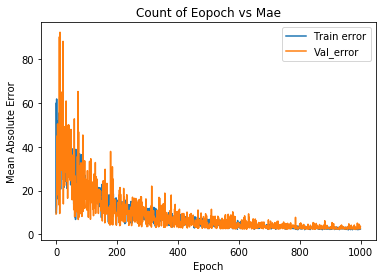

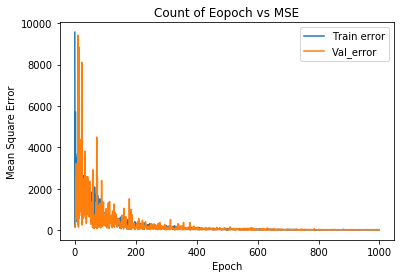

[Out]: Model test loss:14.991757735227926 and  test mae:3.381028413772583 and mse:14.991758346557617 

[OUT]:Plotting predictions


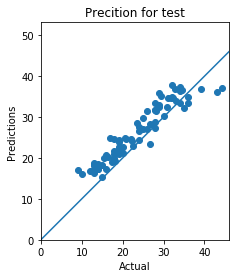

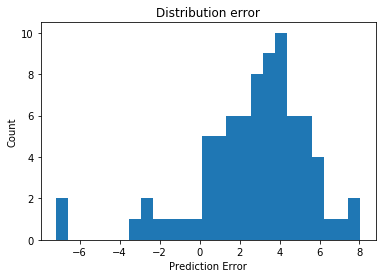

In [8]:
obj.norm_data()
model=obj.create_model()
model=obj.train_model(model)
obj.evaluate_model(model)
pred=obj.model_predict(model)
obj.error_distribution(pred)
#obj.save_model(model)